## Load libraries

In [22]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import geopandas as geopd # podria ser conflictivo
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import cv2
currentDir = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(currentDir, "general_utils"))
import file_management
from other_utils import geodesic_distance

## Load dataset

In [23]:
metadata_df = file_management.load_lzma('Processed Data/metadata_df.lzma')
pan_shape = metadata_df['original_shape']
df = file_management.load_lzma('Processed Data/dataset.lzma')
df, pan_shape

(                 C           B          G          Y          R         RE  \
 0       107.657256  105.357193  97.342775  88.541732  95.685622  89.459027   
 1        91.784712   90.587493  83.710526  75.313386  82.156806  76.768693   
 2        83.503385   82.710320  76.681398  67.729134  75.269409  70.345190   
 3        84.193495   85.336044  78.811437  66.670866  77.237237  72.381910   
 4        81.433053   84.351398  77.746417  62.437795  76.253323  71.598556   
 ...            ...         ...        ...        ...        ...        ...   
 781331  104.206703   77.787087  63.475157  53.618898  38.372640  67.525115   
 781332   97.650652   74.504931  61.771126  50.267717  36.158834  68.151798   
 781333   92.474823   72.207422  60.919111  48.327559  35.174920  68.621811   
 781334   89.714380   70.894560  60.493103  46.740157  33.945028  68.465140   
 781335   91.094601   72.207422  61.558122  47.269291  34.682963  70.501860   
 
                  N         N2    NDVI_1    NDVI_2

## Trees segmentation

In [24]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from collections import Counter

In [25]:
# Firstly we extract the positional data from the Dataframe
pan_shape = metadata_df['original_shape'] 
lats = df['Lats']
longs = df['Longs']
df = df.iloc[:, :-2]
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,SAVI_6,NPQI_1,NPQI_2,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,-0.250487,0.010798,0.013481,0.016159,0.018830,0.021494,0.165608,0.071206,-0.005166,0.888799
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,-0.241003,0.006565,0.008195,0.009820,0.011441,0.013058,0.178328,0.080613,-0.000712,0.895103
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,-0.224845,0.004771,0.005955,0.007136,0.008312,0.009486,0.204094,0.104599,0.011898,0.901394
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.191057,-0.006740,-0.008412,-0.010080,-0.011742,-0.013400,0.254286,0.151960,0.030953,0.917378
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.153523,-0.017603,-0.021971,-0.026325,-0.030667,-0.034995,0.313951,0.210050,0.054507,0.936393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.396989,0.145168,0.181211,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.473595,0.134447,0.167814,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.515550,0.123070,0.153604,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.549930,0.117178,0.146245,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368


In [26]:
img_gray = np.copy(df.loc[:,'NDVI_1'].values).reshape(pan_shape)
thresh = threshold_otsu(img_gray)
binary_clear = img_gray > thresh
label_image = label(binary_clear)
regions = regionprops(label_image)
trees = np.zeros_like(binary_clear)
for region in regions:
    # if region.area > 200:
    #     continue
    # if region.perimeter**2 / region.area > 25:
    #     print('perimeter', region.perimeter**2 / region.area)
    #     continue
    # if region.extent < 0.4:
    #     print('extent', region.extent)
    #     continue
    # if region.eccentricity < 0.5:
    #     print('eccentricity', region.eccentricity)
    #     continue

    trees[label_image == region.label] = 1

trees = trees.astype('uint8')
print(Counter(trees.astype('uint8').flatten()))

Counter({0: 633172, 1: 148164})


## Apply the watershed algorithm to the binary mask

In [27]:
distance = ndi.distance_transform_edt(trees.astype('uint8'))
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=trees)
print('Initial number of trees: %d' % coords.shape[0])
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=trees)
print('Final number of trees: %d' % np.unique(labels).shape[0])

Initial number of trees: 4034
Final number of trees: 2448


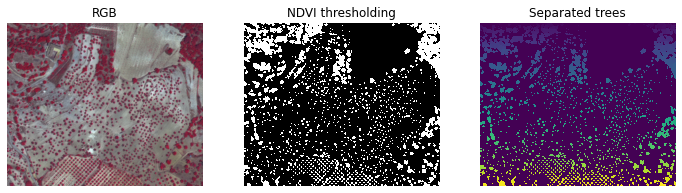

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
ax = axes.ravel()

rgb_df = (255*(df/df.max())).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))
ax[0].imshow(rgb)
ax[0].set_title('RGB')

im=ax[1].imshow(trees, cmap=plt.cm.gray, interpolation='none')
# fig.colorbar(im, ax=ax[1])
ax[1].set_title('NDVI thresholding')

# im = ax[2].imshow(-distance, cmap=plt.cm.gray, interpolation='none')
# # fig.colorbar(im, ax=ax[2])
# ax[2].set_title('Distances')

im = ax[2].imshow(labels, interpolation='none')
# fig.colorbar(im, ax=ax[3])
ax[2].set_title('Separated trees')

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.savefig(os.path.join('Images', 'Trees_segmentation_imagery', 'new_workflow_subplots.png'), dpi=300, transparent=True)
plt.show()

In [29]:
# Assign the labels to the dataframe and include the geographic information
cluster_id = labels.ravel() - 1
df['cluster_id'] = cluster_id
df.loc[df['cluster_id']==-1, 'cluster_id'] = 65535 # background label
df['Lats'] = lats
df['Longs'] = longs
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,0.016159,0.018830,0.021494,0.165608,0.071206,-0.005166,0.888799,65535,39.618415,2.581034
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,0.009820,0.011441,0.013058,0.178328,0.080613,-0.000712,0.895103,65535,39.618415,2.581040
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,0.007136,0.008312,0.009486,0.204094,0.104599,0.011898,0.901394,65535,39.618415,2.581046
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.010080,-0.011742,-0.013400,0.254286,0.151960,0.030953,0.917378,65535,39.618415,2.581052
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.026325,-0.030667,-0.034995,0.313951,0.210050,0.054507,0.936393,65535,39.618415,2.581058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614754,2.586622
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614754,2.586628
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614754,2.586634
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614754,2.586640


## Qpcr labelling

In [30]:
qpcr_df = geopd.read_file('Data/QPCR tests/Dataset_pcr_processed_degrees.geojson') 
qpcr_df

,PCR,VISUAL_SCALE,VARIETAT,geometry
0,0.0,NaN,Guarim,POINT (2.58258 39.61700)
1,1.0,NaN,Morro de vaca,POINT (2.58262 39.61706)
2,1.0,NaN,Verdereta,POINT (2.58270 39.61715)
3,1.0,NaN,Verdereta,POINT (2.58275 39.61721)
4,0.0,NaN,Verdereta,POINT (2.58279 39.61728)
...,...,...,...,...
797,1.0,NaN,ribes,POINT (2.58547 39.61637)
798,0.0,2.0,brot penjant,POINT (2.58556 39.61631)
799,NaN,NaN,vivot,POINT (2.58558 39.61593)
800,NaN,NaN,,POINT (2.58553 39.61586)


In [31]:
qpcr_df["Lat"] = [item.y for item in qpcr_df["geometry"]]
qpcr_df["Lon"] = [item.x for item in qpcr_df["geometry"]]
qpcr_df = qpcr_df[['Lon', 'Lat', 'PCR']]
qpcr_df = qpcr_df.dropna(axis=0)
qpcr_df

,Lon,Lat,PCR
0,2.582577,39.616996,0.0
1,2.582620,39.617064,1.0
2,2.582703,39.617152,1.0
3,2.582747,39.617208,1.0
4,2.582794,39.617281,0.0
...,...,...,...
794,2.585765,39.616452,0.0
795,2.585681,39.616346,0.0
796,2.585504,39.616412,0.0
797,2.585474,39.616372,1.0


In [32]:
infected_trees = qpcr_df.loc[qpcr_df['PCR']==1]
healthy_trees = qpcr_df.loc[qpcr_df['PCR']==0]

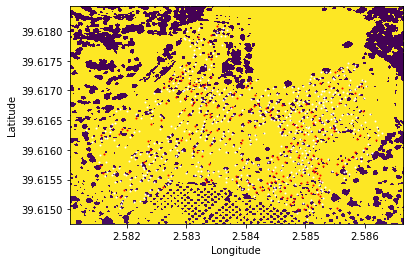

In [33]:
plt.imshow(df['cluster_id'].values.reshape(pan_shape), interpolation='none', 
           extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
# plt.xticks(np.linspace(0, 303, 4), np.round(np.linspace(longs.min(), longs.max(), 4), decimals=3))
# plt.yticks(np.linspace(0, 253, 4), np.round(np.linspace(lats.max(), lats.min(), 4), decimals=3))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)
plt.scatter(infected_trees['Lon'], infected_trees['Lat'], s=1, c='r')
plt.scatter(healthy_trees['Lon'], healthy_trees['Lat'], s=1, c='white')

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Tests_layout_binary_mask.png'), dpi=300, transparent=True)

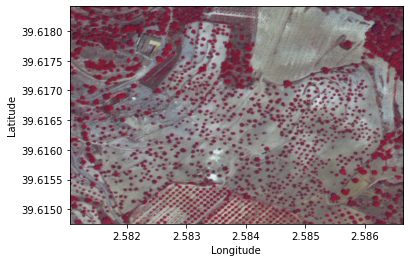

In [34]:
rgb_df = (255*df/df.max()).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))

fig = plt.figure()
plt.imshow(rgb,
          extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)

plt.scatter(infected_trees['Lon'], infected_trees['Lat'], s=(72/300)**2, alpha=1, c='yellow', marker='s')
plt.scatter(healthy_trees['Lon'], healthy_trees['Lat'], s=(72/300)**2, alpha=1, c='indigo', marker='s')

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Tests_layout_rgb.png'), dpi=300, transparent=True)

In [35]:
# We remove the background label from the dataframe and we create a new column for the PCR results
trees_df = df.loc[df['cluster_id'] != 65535]
df['PCR'] = np.nan

# Asociate each tree to the closest QPCR test
trees_lons = trees_df['Longs'].values
trees_lats = trees_df['Lats'].values

qpcr_lons = qpcr_df['Lon'].values
qpcr_lats = qpcr_df['Lat'].values
qpcr_results = qpcr_df['PCR'].values

min_list = []

for lon, lat, pcr in zip(qpcr_lons, qpcr_lats, qpcr_results):
    # Find the closest tree to the QPCR test
    distance_to_trees = geodesic_distance(lon, lat, trees_lons, trees_lats)
    index_min = np.argmin(distance_to_trees)
    min_dist = np.min(distance_to_trees)
    # Check if the distance is less than 3m
    if min_dist < 3: 
        min_list.append(min_dist)
        idx = trees_df.index[index_min]
        cluster_idx = trees_df.loc[idx, 'cluster_id']
        # If the tree has no PCR value, assign the PCR value of the QPCR test
        if np.all(np.isnan(df.loc[df['cluster_id']==cluster_idx, 'PCR'])):
            df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
        # If the tree has a PCR value, check if the PCR value of the QPCR test is 1
        # If it is 1, leave the PCR value of the QPCR test as 1 for all the pixels of the tree
        # If it is 0, assign the PCR value of the QPCR test for all the pixels of the tree
        else:
            if np.mean(df.loc[df['cluster_id']==cluster_idx, 'PCR']) < 1:
                df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
            else:
                pass
            

file_management.save_lzma(df, 'Processed Data/QPCR_labelled_df.lzma', '')

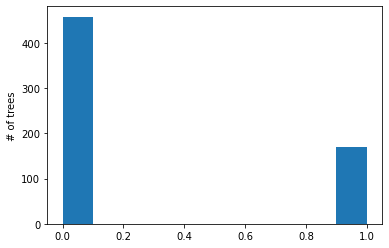

In [36]:
# Remove the trees that have no PCR value
classified_trees_df = df.dropna(axis=0)

# Plot the number of trees per PCR value
classified_trees_df.groupby('cluster_id').mean()['PCR'].hist()
plt.grid(False)
plt.ylabel('# of trees')
path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, '#_trees_per_QPCR_class.png'), dpi=300, transparent=True)

42.76714513556619 39.84387400038457 458 1


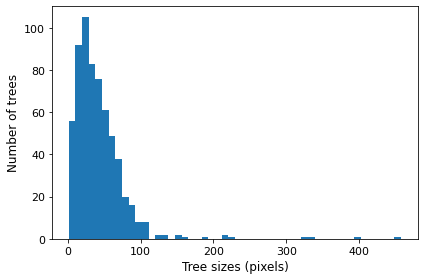

In [37]:
## Explore the size in pixels of the trees
tree_sizes = classified_trees_df.groupby('cluster_id')['cluster_id'].count().values

fig, ax = plt.subplots()
# the histogram of the data
num_bins = 50
n, bins, patches = ax.hist(tree_sizes, num_bins)

ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_ylabel('Number of trees', fontsize=12)
ax.set_xlabel('Tree sizes (pixels)', fontsize=12)
print(np.mean(tree_sizes), np.std(tree_sizes), np.max(tree_sizes), np.min(tree_sizes))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, '#_pixels_per_tree_and_QPCR_class.png'), dpi=300, transparent=True)

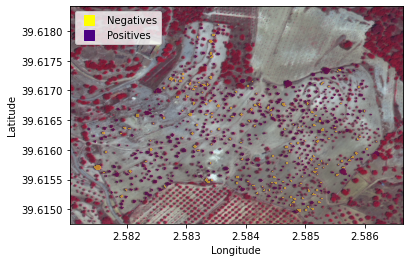

In [38]:
from matplotlib.lines import Line2D

plt.imshow(rgb,
          extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])

plt.imshow(df['PCR'].values.reshape(pan_shape), interpolation='none', 
           extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()], alpha=0.5)
# plt.colorbar(label='Cluster id')
legend_elements = [Line2D([0], [0], marker='s', color='yellow', linestyle='None', label='Negatives', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='s', color='indigo', linestyle='None', label='Positives', markerfacecolor='indigo', markersize=10)]
plt.legend(handles=legend_elements, loc='upper left')

# plt.xticks(np.linspace(0, 303, 4), np.round(np.linspace(longs.min(), longs.max(), 4), decimals=3))
# plt.yticks(np.linspace(0, 253, 4), np.round(np.linspace(lats.max(), lats.min(), 4), decimals=3))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Trees_QPCR_label.png'), dpi=300, transparent=True)